In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from pathlib import Path

from rasterstats import zonal_stats
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob, os
# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
#%% Read in data
root = Path('/home/alal/res/India_Forests/')
code = root / 'Code'
data = root / 'Data'
spatial = data/'Spatial'

## Ingest Buffers around Treated Blocks

In [3]:
block_buf = gpd.read_file(spatial/"Processed/BLOCKS_sch_coded.geojson")
states    = gpd.read_file(spatial/"Vectors/IND_adm1.shp")

In [4]:
states['bound'] = states.boundary
states.geometry = states['bound']
# subset
blocks = block_buf.loc[:, ['sch', "named", "nameb", 'geometry']] 

In [5]:
w, s, e, n = blocks.total_bounds

(68.11009, 87.91343)

(12.62309, 33.22191)

Text(0.5, 1, 'Reserved and Unreserved Blocks under PESA \n 5th Schedule States')

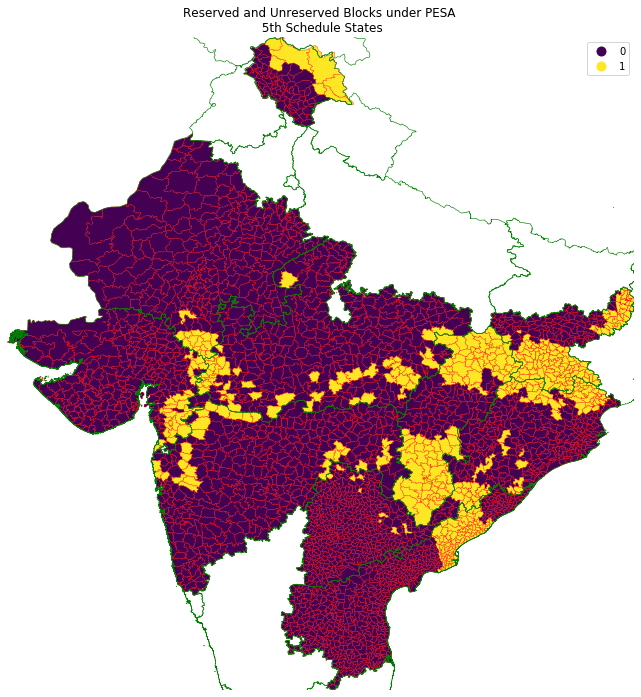

In [6]:
f, ax = plt.subplots(1, figsize=(12,12))
blocks.plot(column='sch', categorical=True, cmap = 'viridis', legend=True,
            edgecolor='r',linewidth=0.3,ax=ax)
states.plot(edgecolor='g',linewidth=0.6,ax=ax)
ax.set_xlim(w, e)
ax.set_ylim(s, n)
ax.set_title('Reserved and Unreserved Blocks under PESA \n 5th Schedule States')
ax.set_axis_off()

# Raster Merge 

In [7]:
rasters = root / 'Data/Spatial/Rasters/'
%ls {rasters}

downloader.sh*
forest_rasters.txt
Hansen_GFC-2017-v1.5_datamask_20N_070E.tif
Hansen_GFC-2017-v1.5_datamask_20N_080E.tif
Hansen_GFC-2017-v1.5_datamask_30N_080E.tif
Hansen_GFC-2017-v1.5_datamask_40N_070E.tif
Hansen_GFC-2017-v1.5_lossyear_20N_070E.tif
Hansen_GFC-2017-v1.5_lossyear_20N_080E.tif
Hansen_GFC-2017-v1.5_lossyear_30N_070E.tif
Hansen_GFC-2017-v1.5_lossyear_30N_080E.tif
Hansen_GFC-2017-v1.5_lossyear_40N_070E.tif
Hansen_GFC-2017-v1.5_treecover2000_20N_070E.tif
Hansen_GFC-2017-v1.5_treecover2000_20N_070E.tif.aux.xml
Hansen_GFC-2017-v1.5_treecover2000_20N_080E.tif
Hansen_GFC-2017-v1.5_treecover2000_30N_070E.tif
Hansen_GFC-2017-v1.5_treecover2000_30N_080E.tif
Hansen_GFC-2017-v1.5_treecover2000_40N_070E.tif
Hansen_GFC-2019-v1.7_gain_30N_080E.tif
Hansen_GFC-2019-v1.7_gain_30N_080E.tif.aux.xml
Hansen_GFC-2019-v1.7_lossyear_30N_080E.tif
Hansen_GFC-2019-v1.7_lossyear_30N_080E.tif.aux.xml
_Hansen_GFC_lossyear_all.tif
_Hansen_GFC_lossyear_all.tif.aux.xml
_Hansen_GFC_treecover2000_all.tif


## Mosaic

In [8]:
rasterlist = [
    'Hansen_GFC-2017-v1.5_treecover2000_20N_070E.tif',
    'Hansen_GFC-2017-v1.5_treecover2000_20N_080E.tif',
    'Hansen_GFC-2017-v1.5_treecover2000_30N_070E.tif',
    'Hansen_GFC-2017-v1.5_treecover2000_30N_080E.tif',
    'Hansen_GFC-2017-v1.5_treecover2000_40N_070E.tif'
]

In [9]:
src_files_to_mosaic = []
for fp in rasterlist:
    src = rasterio.open(rasters/fp)
    src_files_to_mosaic.append(src)

In [10]:
 src_files_to_mosaic

[<open DatasetReader name='/home/alal/res/India_Forests/Data/Spatial/Rasters/Hansen_GFC-2017-v1.5_treecover2000_20N_070E.tif' mode='r'>,
 <open DatasetReader name='/home/alal/res/India_Forests/Data/Spatial/Rasters/Hansen_GFC-2017-v1.5_treecover2000_20N_080E.tif' mode='r'>,
 <open DatasetReader name='/home/alal/res/India_Forests/Data/Spatial/Rasters/Hansen_GFC-2017-v1.5_treecover2000_30N_070E.tif' mode='r'>,
 <open DatasetReader name='/home/alal/res/India_Forests/Data/Spatial/Rasters/Hansen_GFC-2017-v1.5_treecover2000_30N_080E.tif' mode='r'>,
 <open DatasetReader name='/home/alal/res/India_Forests/Data/Spatial/Rasters/Hansen_GFC-2017-v1.5_treecover2000_40N_070E.tif' mode='r'>]

In [11]:
mosaic, out_trans = merge(src_files_to_mosaic)

In [14]:
out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": "EPSG:4326"})

In [15]:
%%time
out_fp = "/home/alal/tmp/mosaic_treecover.tif"
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

CPU times: user 2.92 s, sys: 5.79 s, total: 8.71 s
Wall time: 9.13 s


## Plot

This crashes the kernel

In [ ]:
%%time
f, ax = plt.subplots(1, 2, figsize=(18,12))
blocks.plot(column='sch', categorical=True, cmap = 'viridis', legend=True,
            edgecolor='r',linewidth=0.3,ax=ax[0])
states.plot(edgecolor='g',linewidth=0.6,ax=ax[0])
ax[0].set_xlim(w, e)
ax[0].set_ylim(s, n)
ax[0].set_title('Reserved and Unreserved Blocks under PESA \n 5th Schedule States')
ax[0].set_axis_off()

show(src, 
     title="Forest Cover in 2000", 
     ax=ax[1])
states.plot(edgecolor='g',linewidth=0.6,ax=ax[1])
ax[1].set_xlim(w, e)
ax[1].set_ylim(s, n)
ax[0].set_axis_off()